# 3D Radiomic Features - PCA and LASSO Classification
## Dimensionality Reduction and Feature Selection for Classification

This notebook:
- Loads radiomic features and sample classifications
- Performs PCA for dimensionality reduction and visualization
- Uses LASSO regression for feature selection
- Trains and evaluates classification model
- Reports comprehensive ML metrics

## 1. Imports and Configuration

In [93]:
print("hello")

hello


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import pickle
import json

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All imports successful!")

All imports successful!


## 2. Configuration and Paths

In [95]:
# Paths
BASE_DIR = Path('C:/FeatureEx')
RADIOMICS_DIR = BASE_DIR / 'radiomics_3d'
METADATA_FILE = BASE_DIR / 'classification_metadata.xlsx'
IMAGES_DIR = BASE_DIR / 'preprocessed_3d_data' / 'images'
OUTPUT_DIR = BASE_DIR / 'radio_pca_results'
OUTPUT_DIR.mkdir(exist_ok=True)

# Configuration
NUM_PCA_COMPONENTS = 50  # Number of PCA components to retain
NUM_CLASSES = 5  # Number of classification classes
CLASS_NAMES = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
LASSO_MAX_ITER = 5000
LASSO_ALPHA_MIN = 0.000001
LASSO_ALPHA_MAX = 1.0

print(f"Base directory: {BASE_DIR}")
print(f"Radiomics directory: {RADIOMICS_DIR}")
print(f"Metadata file: {METADATA_FILE}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"\nConfiguration:")
print(f"  PCA components: {NUM_PCA_COMPONENTS}")
print(f"  Number of classes: {NUM_CLASSES}")
print(f"  LASSO alpha range: [{LASSO_ALPHA_MIN}, {LASSO_ALPHA_MAX}]")

Base directory: C:\FeatureEx
Radiomics directory: C:\FeatureEx\radiomics_3d
Metadata file: C:\FeatureEx\classification_metadata.xlsx
Output directory: C:\FeatureEx\radio_pca_results

Configuration:
  PCA components: 50
  Number of classes: 5
  LASSO alpha range: [1e-06, 1.0]


## 3. Load Radiomic Features

In [96]:
# Load radiomic features
print("Loading radiomic features...")
features_pkl = RADIOMICS_DIR / 'radiomics_3d_features.pkl'
with open(features_pkl, 'rb') as f:
    features_data = pickle.load(f)

features_df = features_data['features_df']
feature_names = features_data['feature_names']
sample_ids = features_data['sample_ids']
metadata = features_data['metadata']

print(f"Loaded features:")
print(f"  Samples: {len(features_df)}")
print(f"  Features: {len(feature_names)}")
print(f"  Feature names sample: {feature_names[:5]}")

# Filter out diagnostic features (metadata)
diagnostic_mask = np.array([name.lower().startswith('diagnostic') for name in feature_names])
diagnostic_features = np.array(feature_names)[diagnostic_mask]
feature_names = np.array(feature_names)[~diagnostic_mask]

print(f"\nFiltering diagnostic features:")
print(f"  Diagnostic features removed: {len(diagnostic_features)}")
if len(diagnostic_features) > 0:
    print(f"  Excluded features: {diagnostic_features.tolist()}")
print(f"  Features after filtering: {len(feature_names)}")

# Keep only non-diagnostic columns in dataframe
features_df = features_df[[col for col in features_df.columns if not col.lower().startswith('diagnostic') or col == 'sample_id']]

# Verify sample_id column
if 'sample_id' not in features_df.columns:
    features_df['sample_id'] = sample_ids
    print(f"  Added sample_id column")

print(f"\nDataFrame shape: {features_df.shape}")
print(f"DataFrame columns (first 10): {list(features_df.columns[:10])}")

Loading radiomic features...
Loaded features:
  Samples: 472
  Features: 129
  Feature names sample: ['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python']

Filtering diagnostic features:
  Diagnostic features removed: 22
  Excluded features: ['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size', 'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size', 'diagnostics_Mask-original

## 4. Load Classification Metadata

In [97]:
# Load metadata
print("Loading classification metadata...")
metadata_df = pd.read_excel(METADATA_FILE, sheet_name='samples')

print(f"Loaded metadata:")
print(f"  Samples: {len(metadata_df)}")
print(f"  Columns: {list(metadata_df.columns)}")
print(f"\nMetadata preview:")
print(metadata_df.head())

print(f"\nClass distribution:")
print(metadata_df['label'].value_counts().sort_index())

print(f"\nData split:")
print(metadata_df['split'].value_counts())

Loading classification metadata...
Loaded metadata:
  Samples: 488
  Columns: ['sample_id', 'image_path', 'label', 'age', 'gender', 'split']

Metadata preview:
  sample_id    image_path  label  age gender  split
0      1.5L   1.5L.nii.gz      3   67      F  train
1      1.6L   1.6L.nii.gz      4   55      F  train
2     10.1L  10.1L.nii.gz      2   37      M  train
3     10.2L  10.2L.nii.gz      4   68      F  train
4     10.3L  10.3L.nii.gz      4   58      F  train

Class distribution:
label
0    103
1     94
2     90
3    110
4     91
Name: count, dtype: int64

Data split:
split
train    341
test      74
val       73
Name: count, dtype: int64


## 5. Merge Features with Labels

In [98]:
# Merge features with labels
print("Merging features with classification labels...")

# Create mapping from sample_id to label
label_map = dict(zip(metadata_df['sample_id'], metadata_df['label']))

# Add labels to features dataframe
features_df['class_label'] = features_df['sample_id'].map(label_map)

# Check for unmatched samples
unmatched = features_df['class_label'].isna().sum()
if unmatched > 0:
    print(f"WARNING: {unmatched} samples have no matching label")
    print(f"Removing unmatched samples...")
    features_df = features_df.dropna(subset=['class_label'])
    features_df['class_label'] = features_df['class_label'].astype(int)

print(f"\nMerged data:")
print(f"  Total samples with labels: {len(features_df)}")
print(f"  Total features: {len(feature_names)}")
print(f"\nClass distribution in merged data:")
print(features_df['class_label'].value_counts().sort_index())

# Prepare data for analysis
# Convert feature_names to list if it's still a numpy array
feature_names_list = list(feature_names)
X = features_df[feature_names_list].values  # Feature matrix
y = features_df['class_label'].values   # Labels
sample_ids_final = features_df['sample_id'].values

print(f"\nData shapes:")
print(f"  X (features): {X.shape}")
print(f"  y (labels): {y.shape}")

Merging features with classification labels...

Merged data:
  Total samples with labels: 472
  Total features: 107

Class distribution in merged data:
class_label
0    100
1     90
2     85
3    108
4     89
Name: count, dtype: int64

Data shapes:
  X (features): (472, 107)
  y (labels): (472,)


## 6. Data Preprocessing and Scaling

In [99]:
# Standardize features
print("Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Feature scaling completed:")
print(f"  Mean (should be ~0): {X_scaled.mean(axis=0)[:5]}")
print(f"  Std (should be ~1): {X_scaled.std(axis=0)[:5]}")

# Save scaler for later use
scaler_path = OUTPUT_DIR / 'feature_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"\nScaler saved to: {scaler_path}")

Standardizing features...
Feature scaling completed:
  Mean (should be ~0): [-3.01077430e-17  1.95700330e-16 -6.02154861e-17  3.01077430e-17
  1.20430972e-16]
  Std (should be ~1): [1. 1. 1. 1. 1.]

Scaler saved to: C:\FeatureEx\radio_pca_results\feature_scaler.pkl


## 7. PCA Analysis

Performing PCA...
PCA completed:
  Components: 50
  Explained variance ratio: [0.32887486 0.14931129 0.12571826 0.06764336 0.05177576]
  Cumulative variance: 0.9970


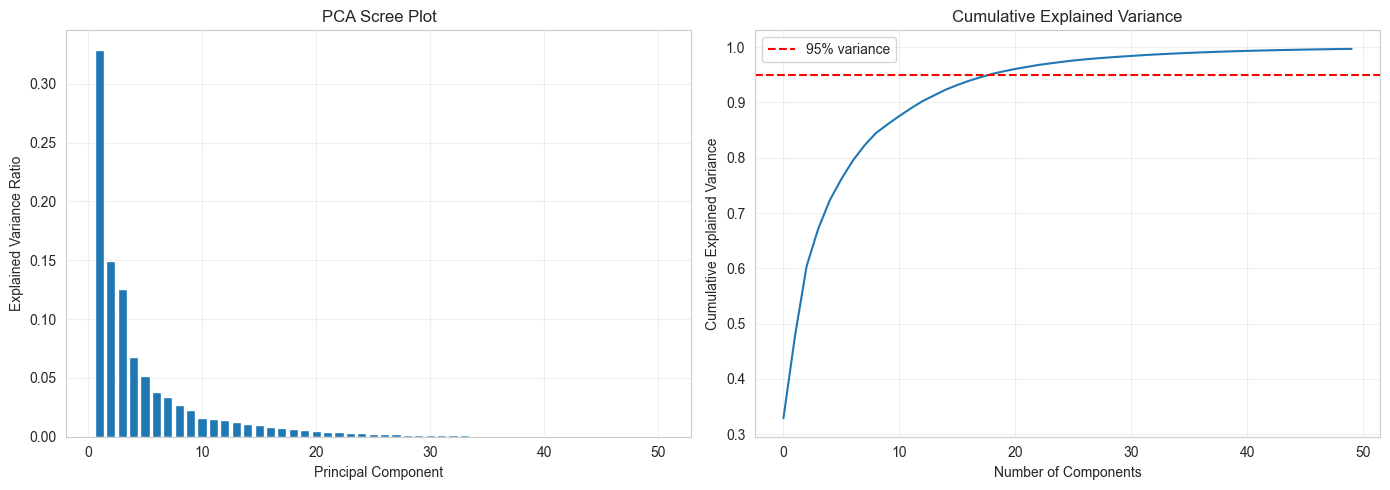


PCA plot saved to: C:\FeatureEx\radio_pca_results\pca_variance_analysis.png
PCA model saved to: C:\FeatureEx\radio_pca_results\pca_model.pkl


In [100]:
# Perform PCA
print("Performing PCA...")
pca = PCA(n_components=NUM_PCA_COMPONENTS)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA completed:")
print(f"  Components: {pca.n_components_}")
print(f"  Explained variance ratio: {pca.explained_variance_ratio_[:5]}")
print(f"  Cumulative variance: {np.cumsum(pca.explained_variance_ratio_)[-1]:.4f}")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, NUM_PCA_COMPONENTS + 1), pca.explained_variance_ratio_)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA Scree Plot')
axes[0].grid(True, alpha=0.3)

# Cumulative explained variance
axes[1].plot(np.cumsum(pca.explained_variance_ratio_))
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'pca_variance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPCA plot saved to: {OUTPUT_DIR / 'pca_variance_analysis.png'}")

# Save PCA model
pca_path = OUTPUT_DIR / 'pca_model.pkl'
with open(pca_path, 'wb') as f:
    pickle.dump(pca, f)
print(f"PCA model saved to: {pca_path}")

## 8. PCA Visualization by Class

Visualizing PCA results...


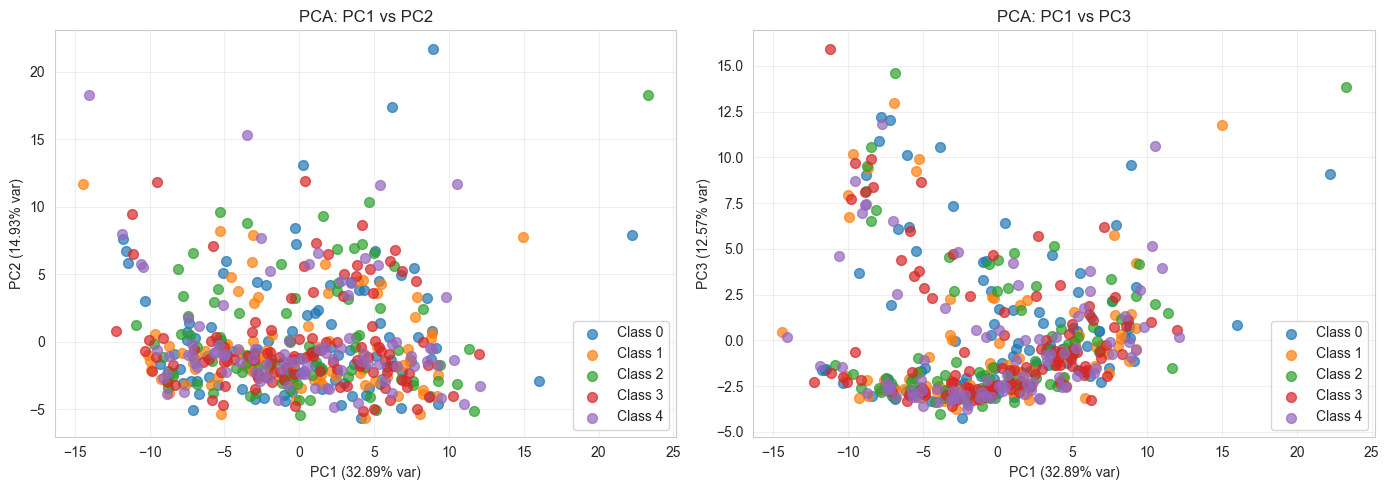

PCA scatter plot saved to: C:\FeatureEx\radio_pca_results\pca_scatter_plot.png


In [101]:
# Visualize PCA results
print("Visualizing PCA results...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 2D PCA plot (PC1 vs PC2)
for class_label in np.unique(y):
    mask = y == class_label
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   label=f'Class {class_label}', alpha=0.7, s=50)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var)')
axes[0].set_title('PCA: PC1 vs PC2')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2D PCA plot (PC1 vs PC3)
for class_label in np.unique(y):
    mask = y == class_label
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 2], 
                   label=f'Class {class_label}', alpha=0.7, s=50)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var)')
axes[1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} var)')
axes[1].set_title('PCA: PC1 vs PC3')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'pca_scatter_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"PCA scatter plot saved to: {OUTPUT_DIR / 'pca_scatter_plot.png'}")

## 9. LASSO Feature Selection

In [102]:
# LASSO for feature selection
print("Performing LASSO feature selection...")
print(f"Training LASSO on {len(feature_names)} features (after excluding diagnostic features)...")

# Use LassoCV to find optimal alpha
lasso_cv = LassoCV(
    cv=5,
    max_iter=LASSO_MAX_ITER,
    alphas=np.logspace(np.log10(LASSO_ALPHA_MIN), np.log10(LASSO_ALPHA_MAX), 100),
    random_state=99
)
print(y)


print("Assessing Dummy Regressor")
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
score = cross_val_score(dummy, X_scaled, y, cv=5, scoring="r2")
print("Dummy score: ", score.mean())

print("Assessing non-linear model ")
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor()
print("nonlinear performance: ",cross_val_score(rf, X, y, cv=5, scoring="r2").mean())











print("Training LassoCV (this may take a moment)...")
lasso_cv.fit(X_scaled, y)

print(f"\nLASSO training completed:")
print(f"  Optimal alpha: {lasso_cv.alpha_:.6f}")
print(f"  CV score (R²): {lasso_cv.score(X_scaled, y):.4f}")

# Get selected features
selected_features_mask = lasso_cv.coef_ != 0
feature_names_list = list(feature_names)
selected_features = np.array(feature_names_list)[selected_features_mask]
selected_indices = np.where(selected_features_mask)[0]

print(f"\nFeature selection results:")
print(f"  Features after diagnostic filtering: {len(feature_names_list)}")
print(f"  Selected features: {len(selected_features)}")
print(f"  Selection ratio: {len(selected_features) / len(feature_names_list) * 100:.1f}%")

print(f"\nTop selected features:")
top_coefs_idx = np.argsort(np.abs(lasso_cv.coef_[selected_features_mask]))[-10:][::-1]
for i, idx in enumerate(top_coefs_idx, 1):
    feat_idx = selected_indices[idx]
    print(f"  {i}. {feature_names_list[feat_idx]:50s} (coef: {lasso_cv.coef_[feat_idx]:8.4f})")

# Save LASSO model and selected features
lasso_path = OUTPUT_DIR / 'lasso_model.pkl'
with open(lasso_path, 'wb') as f:
    pickle.dump(lasso_cv, f)

selected_features_info = {
    'feature_names': selected_features.tolist(),
    'feature_indices': selected_indices.tolist(),
    'coefficients': lasso_cv.coef_[selected_features_mask].tolist(),
    'alpha': lasso_cv.alpha_,
    'cv_score': lasso_cv.score(X_scaled, y)
}

with open(OUTPUT_DIR / 'selected_features.json', 'w') as f:
    json.dump(selected_features_info, f, indent=2)

print(f"\nLASSO model saved to: {lasso_path}")
print(f"Selected features info saved to: {OUTPUT_DIR / 'selected_features.json'}")

Performing LASSO feature selection...
Training LASSO on 107 features (after excluding diagnostic features)...
[3 4 2 4 4 1 2 2 2 4 3 2 4 1 3 1 3 4 0 3 1 4 3 0 0 2 2 1 3 3 2 3 3 0 2 4 2
 4 0 1 3 0 3 1 1 0 1 4 1 3 3 3 4 2 0 3 1 3 1 1 3 4 1 1 3 1 1 3 3 0 4 4 1 4
 1 0 3 3 3 4 0 4 4 0 0 0 0 3 2 2 0 2 2 0 2 4 1 1 0 3 0 3 1 0 4 2 3 2 2 2 4
 2 0 4 1 2 0 1 1 3 4 2 0 3 4 3 4 4 2 4 3 4 2 2 3 1 1 4 0 4 3 3 3 3 3 2 1 3
 0 0 0 0 2 0 3 4 0 2 2 0 4 0 1 3 2 0 3 0 0 1 3 3 1 2 0 4 0 0 2 0 1 1 0 2 1
 4 3 1 3 2 2 0 4 3 1 2 0 0 3 2 4 2 3 3 2 3 2 1 2 2 3 3 0 0 1 0 2 3 0 0 1 1
 2 3 1 0 3 3 0 1 0 3 4 4 2 0 0 2 2 2 3 0 3 2 0 3 3 2 0 2 0 4 1 1 1 2 4 0 3
 0 3 0 4 3 2 0 0 3 2 2 4 2 2 2 4 0 3 0 4 3 4 2 3 2 0 3 3 4 4 2 3 0 4 4 0 4
 2 3 0 3 4 4 0 2 1 0 1 1 2 1 1 2 1 1 1 0 0 0 2 4 1 1 2 1 0 4 3 1 0 3 4 3 0
 3 2 3 1 1 2 0 1 4 1 1 0 3 1 2 3 4 0 4 3 3 3 4 3 4 3 2 3 4 1 3 1 2 0 2 3 1
 1 4 4 0 3 4 0 1 1 0 1 0 4 4 0 4 4 4 2 3 1 2 4 0 4 3 4 0 3 4 3 1 4 3 0 4 1
 1 4 3 1 3 1 1 2 1 0 4 4 3 0 3 2 3 3 1 2 3 0 0 4 2 3 2 0 0 1 3 4 

## 10. LASSO Coefficients Visualization

Visualizing LASSO coefficients...


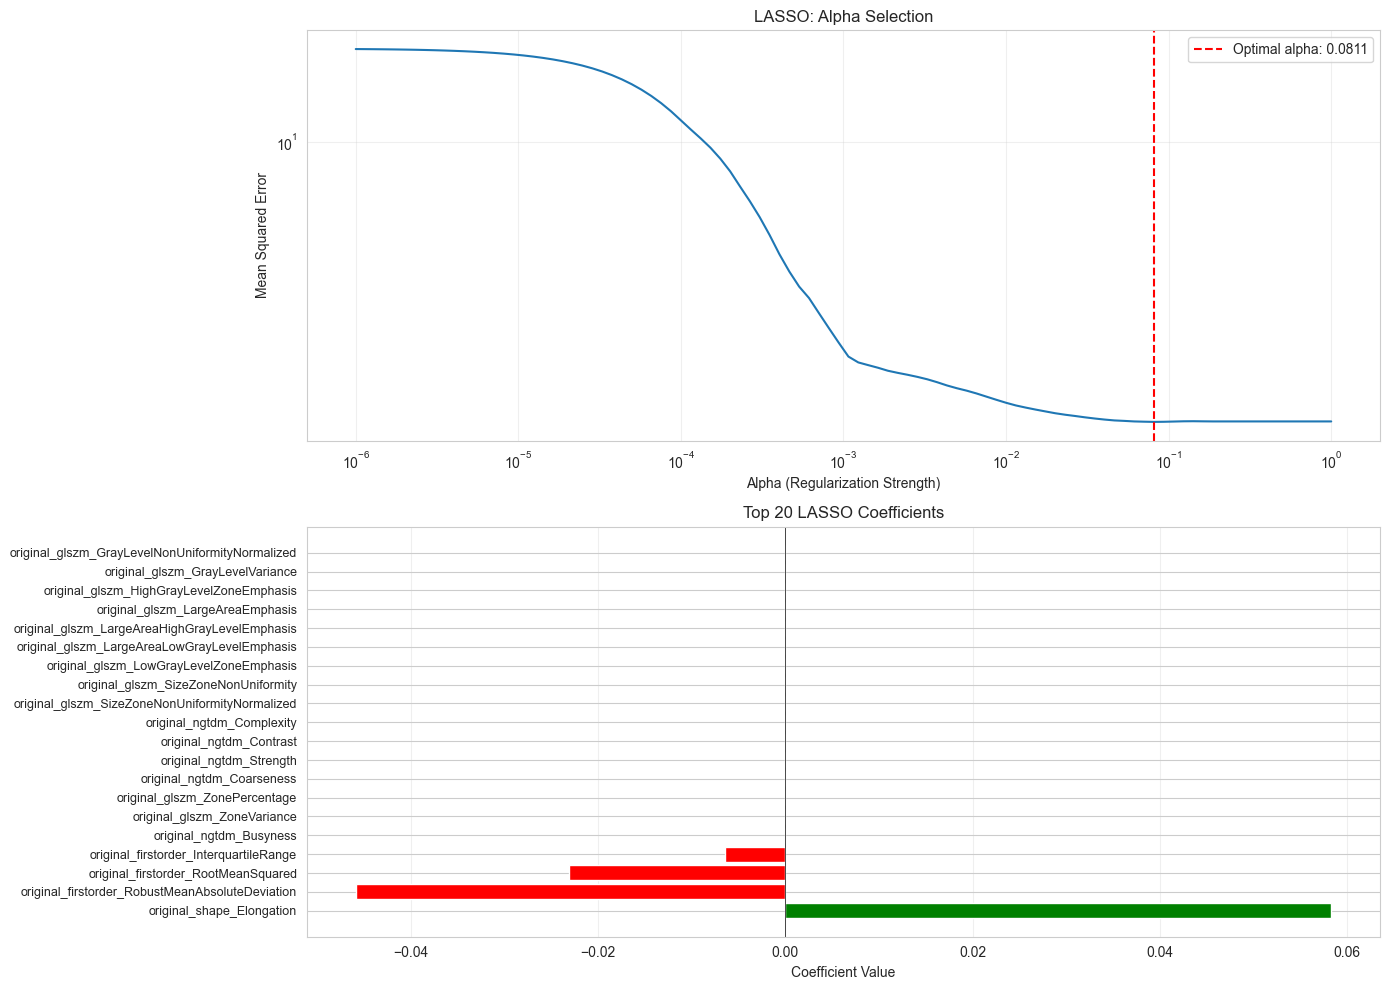

LASSO coefficients plot saved to: C:\FeatureEx\radio_pca_results\lasso_coefficients.png


In [103]:
# Visualize LASSO coefficients
print("Visualizing LASSO coefficients...")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Alpha path
axes[0].loglog(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1))
axes[0].axvline(lasso_cv.alpha_, color='r', linestyle='--', label=f'Optimal alpha: {lasso_cv.alpha_:.4f}')
axes[0].set_xlabel('Alpha (Regularization Strength)')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title('LASSO: Alpha Selection')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Top coefficients
top_n = 20
feature_names_list = list(feature_names)
top_indices = np.argsort(np.abs(lasso_cv.coef_))[-top_n:][::-1]
top_features = [feature_names_list[i] for i in top_indices]
top_coefs = lasso_cv.coef_[top_indices]

colors = ['green' if c > 0 else 'red' for c in top_coefs]
axes[1].barh(range(len(top_coefs)), top_coefs, color=colors)
axes[1].set_yticks(range(len(top_coefs)))
axes[1].set_yticklabels(top_features, fontsize=9)
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title(f'Top {top_n} LASSO Coefficients')
axes[1].axvline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lasso_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"LASSO coefficients plot saved to: {OUTPUT_DIR / 'lasso_coefficients.png'}")

## 11. Train Classification Model using Selected Features

In [104]:
# Use selected features for classification
print("Training classification model with selected features...")

X_selected = X_scaled[:, selected_features_mask]

print(f"\nUsing {len(selected_features)} selected features for classification")
print(f"Feature matrix shape: {X_selected.shape}")

# Train logistic regression classifier
classifier = OneVsRestClassifier(
    LogisticRegression(max_iter=1000, random_state=42)
)

print("Training classifier...")
classifier.fit(X_selected, y)
print("Training completed!")

# Make predictions on training data
y_pred = classifier.predict(X_selected)
y_pred_proba = classifier.predict_proba(X_selected)

print(f"\nPredictions generated:")
print(f"  Predicted labels shape: {y_pred.shape}")
print(f"  Prediction probabilities shape: {y_pred_proba.shape}")

# Save classifier
classifier_path = OUTPUT_DIR / 'classifier_model.pkl'
with open(classifier_path, 'wb') as f:
    pickle.dump(classifier, f)
print(f"\nClassifier saved to: {classifier_path}")

Training classification model with selected features...

Using 4 selected features for classification
Feature matrix shape: (472, 4)
Training classifier...
Training completed!

Predictions generated:
  Predicted labels shape: (472,)
  Prediction probabilities shape: (472, 5)

Classifier saved to: C:\FeatureEx\radio_pca_results\classifier_model.pkl


## 12. Comprehensive Model Evaluation

In [105]:
# Calculate metrics
print("\n" + "="*70)
print("CLASSIFICATION PERFORMANCE METRICS")
print("="*70)

# Basic metrics
accuracy = accuracy_score(y, y_pred)
precision_weighted = precision_score(y, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y, y_pred, average='weighted', zero_division=0)
f1_weighted = f1_score(y, y_pred, average='weighted', zero_division=0)

print(f"\nOverall Metrics (weighted average):")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision_weighted:.4f}")
print(f"  Recall:    {recall_weighted:.4f}")
print(f"  F1-Score:  {f1_weighted:.4f}")

# Per-class metrics
print(f"\nPer-Class Metrics:")
for class_label in np.unique(y):
    mask = y == class_label
    class_acc = accuracy_score(y[mask], y_pred[mask])
    class_prec = precision_score(y[mask], y_pred[mask], average='weighted', zero_division=0)
    class_rec = recall_score(y[mask], y_pred[mask], average='weighted', zero_division=0)
    class_f1 = f1_score(y[mask], y_pred[mask], average='weighted', zero_division=0)
    
    print(f"\n  Class {class_label}: ({mask.sum()} samples)")
    print(f"    Accuracy:  {class_acc:.4f}")
    print(f"    Precision: {class_prec:.4f}")
    print(f"    Recall:    {class_rec:.4f}")
    print(f"    F1-Score:  {class_f1:.4f}")

print(f"\n" + "="*70)


CLASSIFICATION PERFORMANCE METRICS

Overall Metrics (weighted average):
  Accuracy:  0.2564
  Precision: 0.2030
  Recall:    0.2564
  F1-Score:  0.1994

Per-Class Metrics:

  Class 0: (100 samples)
    Accuracy:  0.4100
    Precision: 1.0000
    Recall:    0.4100
    F1-Score:  0.5816

  Class 1: (90 samples)
    Accuracy:  0.1111
    Precision: 1.0000
    Recall:    0.1111
    F1-Score:  0.2000

  Class 2: (85 samples)
    Accuracy:  0.0000
    Precision: 0.0000
    Recall:    0.0000
    F1-Score:  0.0000

  Class 3: (108 samples)
    Accuracy:  0.5926
    Precision: 1.0000
    Recall:    0.5926
    F1-Score:  0.7442

  Class 4: (89 samples)
    Accuracy:  0.0674
    Precision: 1.0000
    Recall:    0.0674
    F1-Score:  0.1263



## 13. Confusion Matrix


Confusion Matrix:
[[41  5  0 46  8]
 [26 10  0 47  7]
 [29  7  0 43  6]
 [31  7  0 64  6]
 [23  7  0 53  6]]

Confusion Matrix shape: (5, 5)


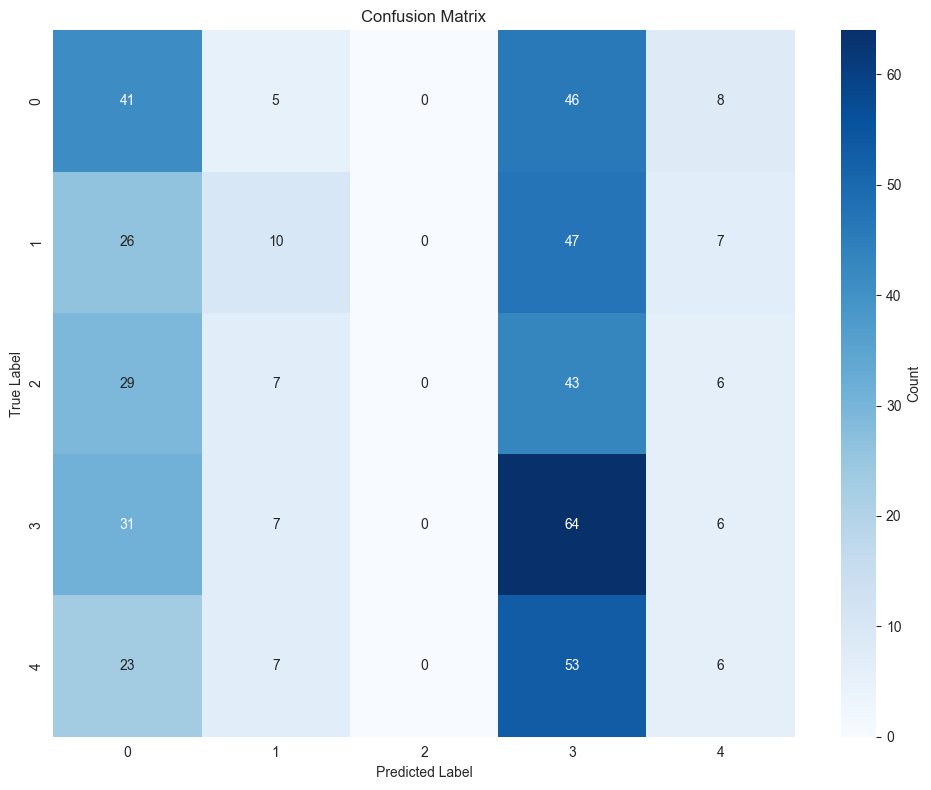


Confusion matrix plot saved to: C:\FeatureEx\radio_pca_results\confusion_matrix.png


In [106]:
# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y, y_pred)
print(cm)
print(f"\nConfusion Matrix shape: {cm.shape}")

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(NUM_CLASSES), 
            yticklabels=range(NUM_CLASSES),
            cbar_kws={'label': 'Count'},
            ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nConfusion matrix plot saved to: {OUTPUT_DIR / 'confusion_matrix.png'}")

# Save confusion matrix
np.save(OUTPUT_DIR / 'confusion_matrix.npy', cm)

## 14. Detailed Classification Report

In [107]:
# Classification report
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y, y_pred, target_names=[f'Class {i}' for i in range(NUM_CLASSES)]))

# Save classification report
report_dict = classification_report(y, y_pred, output_dict=True, 
                                   target_names=[f'Class {i}' for i in range(NUM_CLASSES)])
with open(OUTPUT_DIR / 'classification_report.json', 'w') as f:
    json.dump(report_dict, f, indent=2)

print(f"\nClassification report saved to: {OUTPUT_DIR / 'classification_report.json'}")


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0       0.27      0.41      0.33       100
     Class 1       0.28      0.11      0.16        90
     Class 2       0.00      0.00      0.00        85
     Class 3       0.25      0.59      0.35       108
     Class 4       0.18      0.07      0.10        89

    accuracy                           0.26       472
   macro avg       0.20      0.24      0.19       472
weighted avg       0.20      0.26      0.20       472


Classification report saved to: C:\FeatureEx\radio_pca_results\classification_report.json


## 15. ROC Curves (One-vs-Rest)

## 15. ROC Curves (One-vs-Rest)


Calculating ROC curves...


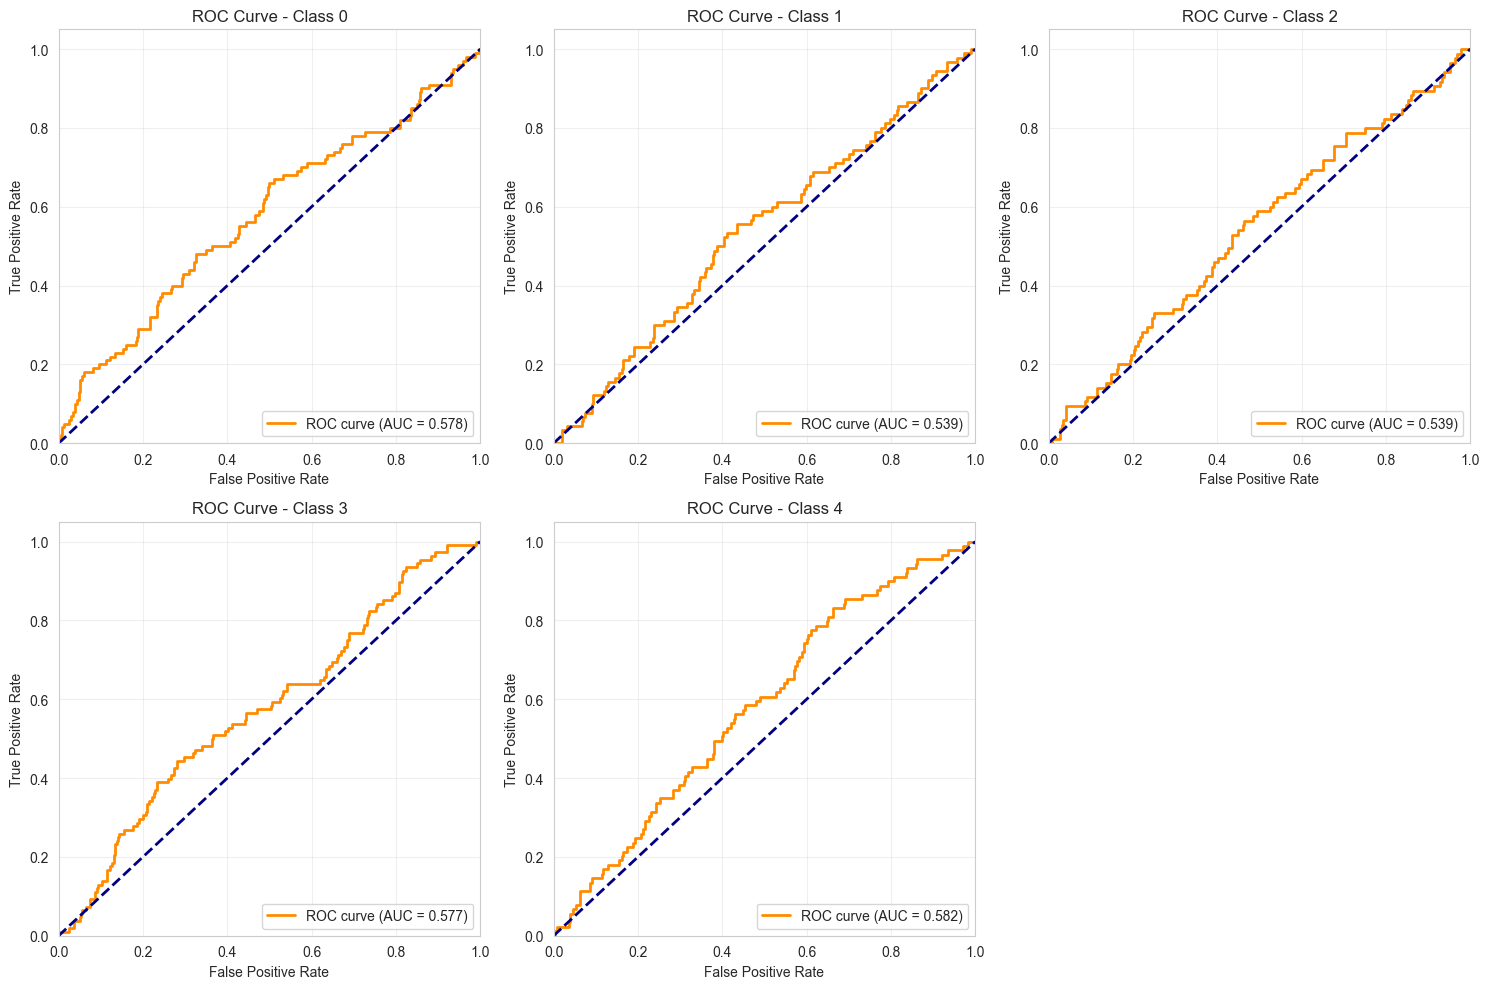


ROC-AUC Scores:
  Class 0: 0.5779
  Class 1: 0.5393
  Class 2: 0.5393
  Class 3: 0.5773
  Class 4: 0.5822

ROC curves plot saved to: C:\FeatureEx\radio_pca_results\roc_curves.png


In [108]:
# ROC curves for each class
print("\nCalculating ROC curves...")

y_bin = label_binarize(y, classes=range(NUM_CLASSES))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

roc_auc_scores = {}

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores[f'Class {i}'] = roc_auc
    
    axes[i].plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC Curve - Class {i}')
    axes[i].legend(loc="lower right")
    axes[i].grid(True, alpha=0.3)

# Remove the extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nROC-AUC Scores:")
for class_name, score in roc_auc_scores.items():
    print(f"  {class_name}: {score:.4f}")

print(f"\nROC curves plot saved to: {OUTPUT_DIR / 'roc_curves.png'}")

## 16. Metrics Summary and Export

In [109]:
# Create comprehensive metrics dictionary
feature_names_list = list(feature_names)
metrics_summary = {
    'overall_metrics': {
        'accuracy': float(accuracy),
        'precision_weighted': float(precision_weighted),
        'recall_weighted': float(recall_weighted),
        'f1_score_weighted': float(f1_weighted)
    },
    'roc_auc_scores': roc_auc_scores,
    'confusion_matrix': cm.tolist(),
    'model_info': {
        'features_after_diagnostic_filtering': len(feature_names_list),
        'selected_features': len(selected_features),
        'selection_ratio': float(len(selected_features) / len(feature_names_list)),
        'pca_components': NUM_PCA_COMPONENTS,
        'pca_explained_variance': float(np.cumsum(pca.explained_variance_ratio_)[-1]),
        'lasso_alpha': float(lasso_cv.alpha_),
        'total_samples': len(y),
        'num_classes': NUM_CLASSES
    },
    'classification_report': report_dict
}

# Save metrics
with open(OUTPUT_DIR / 'metrics_summary.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)

print("\n" + "="*70)
print("METRICS SAVED")
print("="*70)
print(f"\nAll metrics saved to: {OUTPUT_DIR / 'metrics_summary.json'}")

print(f"\nGenerated files:")
for file in sorted(OUTPUT_DIR.glob('*')):
    if file.is_file():
        print(f"  - {file.name}")


METRICS SAVED

All metrics saved to: C:\FeatureEx\radio_pca_results\metrics_summary.json

Generated files:
  - classification_report.json
  - classifier_model.pkl
  - confusion_matrix.npy
  - confusion_matrix.png
  - feature_scaler.pkl
  - lasso_coefficients.png
  - lasso_model.pkl
  - metrics_summary.json
  - pca_model.pkl
  - pca_scatter_plot.png
  - pca_variance_analysis.png
  - roc_curves.png
  - selected_features.json


## 17. Summary and Conclusions

In [110]:
print("\n" + "="*70)
print("ANALYSIS SUMMARY")
print("="*70)

feature_names_list = list(feature_names)

print(f"\n1. FEATURE FILTERING")
print(f"   - Excluded diagnostic features (metadata)")
print(f"   - Features after filtering: {len(feature_names_list)}")

print(f"\n2. PCA ANALYSIS")
print(f"   - Reduced {len(feature_names_list)} features to {NUM_PCA_COMPONENTS} components")
print(f"   - Retained {np.cumsum(pca.explained_variance_ratio_)[-1]:.2%} of variance")

print(f"\n3. LASSO FEATURE SELECTION")
print(f"   - Selected {len(selected_features)} features ({len(selected_features)/len(feature_names_list)*100:.1f}%)")
print(f"   - Optimal regularization alpha: {lasso_cv.alpha_:.6f}")

print(f"\n4. CLASSIFICATION PERFORMANCE")
print(f"   - Overall Accuracy: {accuracy:.4f}")
print(f"   - Weighted Precision: {precision_weighted:.4f}")
print(f"   - Weighted Recall: {recall_weighted:.4f}")
print(f"   - Weighted F1-Score: {f1_weighted:.4f}")

print(f"\n5. CLASS-SPECIFIC PERFORMANCE")
for class_label in np.unique(y):
    mask = y == class_label
    class_acc = accuracy_score(y[mask], y_pred[mask])
    print(f"   - Class {class_label}: {class_acc:.4f} accuracy ({mask.sum()} samples)")

print(f"\n6. OUTPUT DIRECTORY")
print(f"   - Results saved to: {OUTPUT_DIR}")
print(f"   - Plots: PCA, LASSO coefficients, confusion matrix, ROC curves")
print(f"   - Models: PCA, LASSO, Classifier")
print(f"   - Metrics: Comprehensive JSON summary")

print(f"\n" + "="*70)


ANALYSIS SUMMARY

1. FEATURE FILTERING
   - Excluded diagnostic features (metadata)
   - Features after filtering: 107

2. PCA ANALYSIS
   - Reduced 107 features to 50 components
   - Retained 99.70% of variance

3. LASSO FEATURE SELECTION
   - Selected 4 features (3.7%)
   - Optimal regularization alpha: 0.081113

4. CLASSIFICATION PERFORMANCE
   - Overall Accuracy: 0.2564
   - Weighted Precision: 0.2030
   - Weighted Recall: 0.2564
   - Weighted F1-Score: 0.1994

5. CLASS-SPECIFIC PERFORMANCE
   - Class 0: 0.4100 accuracy (100 samples)
   - Class 1: 0.1111 accuracy (90 samples)
   - Class 2: 0.0000 accuracy (85 samples)
   - Class 3: 0.5926 accuracy (108 samples)
   - Class 4: 0.0674 accuracy (89 samples)

6. OUTPUT DIRECTORY
   - Results saved to: C:\FeatureEx\radio_pca_results
   - Plots: PCA, LASSO coefficients, confusion matrix, ROC curves
   - Models: PCA, LASSO, Classifier
   - Metrics: Comprehensive JSON summary

